# Taxi order forecast

The Sweet Lift Taxi company has collected historical data on taxi orders at airports for the previous 6 months. With this data, a taxi order forecast for the upcoming hour would provide drivers with the necessary information to determine if the upcoming
time will be busy or not, ultimately attracting more drivers during peak hours. Multiple models were built and fine-tuned, and predictions were gathered to find the best performing model that yielded the best root squared mean error (RMSE).

## Data preparation

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings

### Data preprocessing

1. <b>Convert data types</b>
    - The <b><mark>datetime</mark></b> field, which was converted to the Series index, needed to be converted to a datetime data type for future resampling and analysis.</br></br>

2. <b>Missing and duplicate values</b>
    - There were no missing values or duplicate rows in the dataset. No clean-up here needed.</br></br>
    
3. <b>Resampling</b>
    - The time interval frequency of the <b><mark>datetime</mark></b> was changed from 10 minutes to <font color='red'><b>1 hour</b></font>. This technique decreased the number of data points in the dataset, smoothed out the data, and made the time interval a time that is more impactful.

#### Data overview

In [2]:
# Load data into a pandas DataFrame
url = 'https://raw.githubusercontent.com/rmodesitt/data-projects-TripleTen/refs/heads/main/time-series-taxi/taxi.csv'
data = pd.read_csv(url)

In [3]:
# Display DataFrame basic info
display(data.info())
print('First date in dataset:', data.iloc[0]['datetime'])
print('Last date in dataset:', data.iloc[-1]['datetime'])
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

First date in dataset: 2018-03-01 00:00:00
Last date in dataset: 2018-08-31 23:50:00


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


#### Convert data types

In [4]:
# Convert 'datetime' field to datetime data type
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

# Set 'datetime' field as the index
data = data.set_index('datetime')

# Display Dataframe and DataFrame basic info
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


#### Missing and duplicate values

In [5]:
# Identify missing values
display(data.isna().sum())

num_orders    0
dtype: int64

In [6]:
# Identify duplicate rows
display(data.index.duplicated().sum())

0

#### Resampling

In [7]:
# Check if data is in chronological order
display(data.index.is_monotonic)

True


ORIGINAL DATAFRAME


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



RESAMPLED DATAFRAME


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Text(0, 0.5, '# of orders')

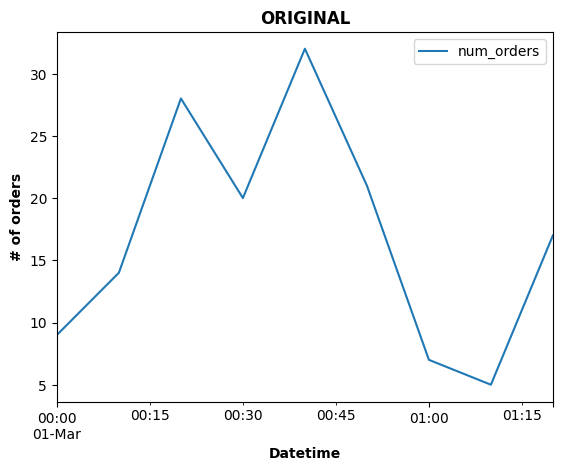

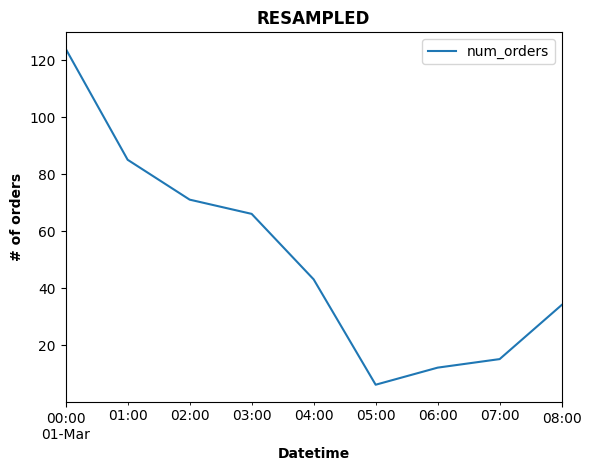

In [8]:
# Display original Dataframe
print()
print('ORIGINAL DATAFRAME')
display(data.head())

# Display a plot of first 10 records
data.iloc[:9].plot()
plt.title('ORIGINAL', fontweight='bold')
plt.xlabel('Datetime', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')

# --------------------------------------

# Resample 'datetime' field by one hour
data = data.resample('1H').sum()

# Display resampled Dataframe
print()
print('RESAMPLED DATAFRAME')
display(data.head())

# Display a plot of the first 10 records
data.iloc[:9].plot()
plt.title('RESAMPLED', fontweight='bold')
plt.xlabel('Datetime', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')

## Analysis

6 months of historical data was provided, set at 1 hour time intervals. That is a lot of data! What the data is telling us can vary depending on the time interval you are looking at. So, to get a good idea of the patterns in the data at *all scales*, rolling means, trends, seasonality, and other analysis were gathered and analyzed over 3 time frequencies: the full <b>6 months</b>, <b>1 month</b>, and a <b>4-day</b> period.

### Raw data

The initial look at the data without any mean or seasonal analysis still shows us some basic trends among the different time frequencies. For the full <b>6 month</b> dataset, there is a slight increase in the number of taxi orders in the later months, August and September being the months with the most orders. There is a clear increase as the months progress. 
</br>
</br>
The <b>monthly</b> view is a bit difficult to decipher, showing no clear trends. However, there doesn't seem to be any big fluctuations in orders throughout the days in the month, implying there might be seasonality.
</br>
</br>
Lastly, for the <b>4 day</b> period there is a clear pattern in orders at different times of the day. Late nights and early mornings clearly have more taxi orders than early and late afternoons. This makes sense because most people prefer to have early morning or late evening / night flight times.

<b>6 months</b>

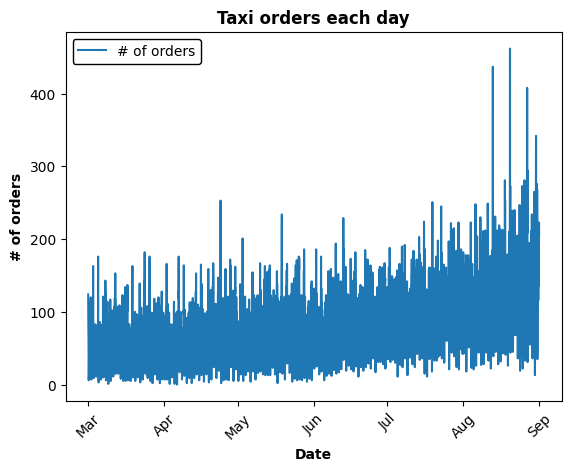

In [9]:
# Plot raw data
labels = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
fig, ax = plt.subplots()
plt.plot(data.index, data['num_orders'])
plt.xlabel('Date', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')
plt.xticks(ticks=ax.get_xticks(), labels=labels, rotation=45)
plt.title('Taxi orders each day', fontweight='bold')
plt.legend(labels=['# of orders'], loc='upper left', framealpha=1, edgecolor='black')
plt.show()

<b>1 month</b>

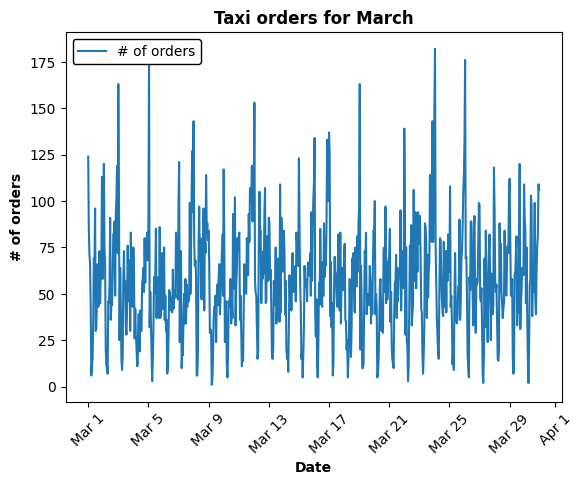

In [10]:
# Plot raw data for 1 month
labels = ['Mar 1', 'Mar 5', 'Mar 9', 'Mar 13', 'Mar 17', 'Mar 21', 'Mar 25', 'Mar 29', 'Apr 1']
fig, ax = plt.subplots()
plt.plot(data.iloc[:720].index, data['num_orders'].iloc[:720])
plt.xlabel('Date', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')
plt.xticks(ticks=ax.get_xticks(), labels=labels, rotation=45)
plt.title('Taxi orders for March', fontweight='bold')
plt.legend(labels=['# of orders'], loc='upper left', framealpha=1, edgecolor='black')
plt.show()

<b>4 days</b>

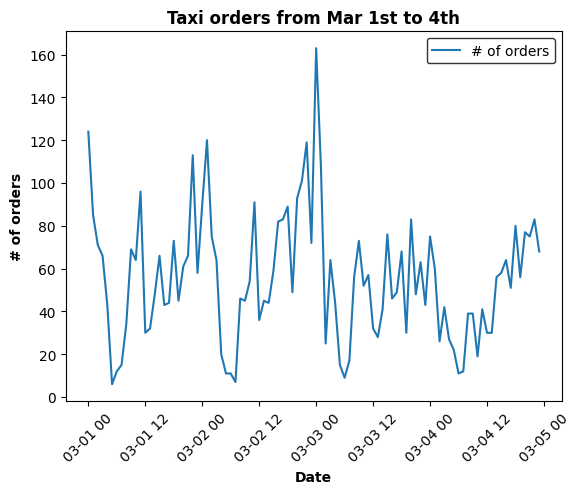

In [11]:
# Plot raw data for 4-day period (Mar 1st to 4th)
fig, ax = plt.subplots()
plt.plot(data.iloc[:96].index, data['num_orders'].iloc[:96])
plt.xlabel('Date', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')
plt.xticks(rotation=45)
plt.title('Taxi orders from Mar 1st to 4th', fontweight='bold')
plt.legend(labels=['# of orders'], edgecolor='black')
plt.show()

### Rolling mean and standard deviation

The rolling means and standard deviations for the different time frequencies presented similar themes and findings, but there is more provided detail and clarity because small variances in the data have been smoothed out. For the full <b>6 month</b> dataset, the same increase in orders is presented in the later months.

For the <b>monthly</b> period, there is additional detail with the rolling means that was difficult to tell in the raw data. The highest number of orders seem to be around weekends, implying that most people prefer to return or leave for travel on Saturday or Sunday vs during the week.

For the <b>4 day</b> period, same theme, but it is more clearly visualized. Mornings and nights yield the highest number of orders.

In [12]:
# Calculate rolling means
data_analysis = data.copy()
data_analysis['rolling_mean'] = data_analysis.rolling(72).mean()
data_analysis['rolling_mean_mon'] = data_analysis['num_orders'].rolling(24).mean()
data_analysis['rolling_mean_day'] = data_analysis['num_orders'].rolling(12).mean()

# Calculate rolling std devs
data_analysis['rolling_std'] = data_analysis['num_orders'].rolling(72).std()
data_analysis['rolling_std_mon'] = data_analysis['num_orders'].rolling(24).std()
data_analysis['rolling_std_day'] = data_analysis['num_orders'].rolling(12).std()

<b>6 months</b>

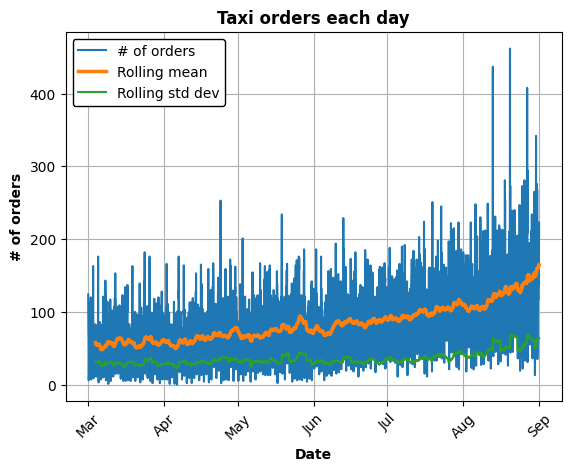

In [13]:
# Plot data for all 6 months
labels = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
fig, ax = plt.subplots()
plt.plot(data_analysis.index, data_analysis['num_orders'])
plt.plot(data_analysis.index, data_analysis['rolling_mean'], linewidth=2.5)
plt.plot(data_analysis.index, data_analysis['rolling_std'], linewidth=1.5)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')
plt.xticks(ticks=ax.get_xticks(), labels=labels, rotation=45)
plt.title('Taxi orders each day', fontweight='bold')
plt.legend(labels=['# of orders', 'Rolling mean', 'Rolling std dev'], loc='upper left', framealpha=1, edgecolor='black')
ax.grid('on')
plt.show()

<b>1 month</b>

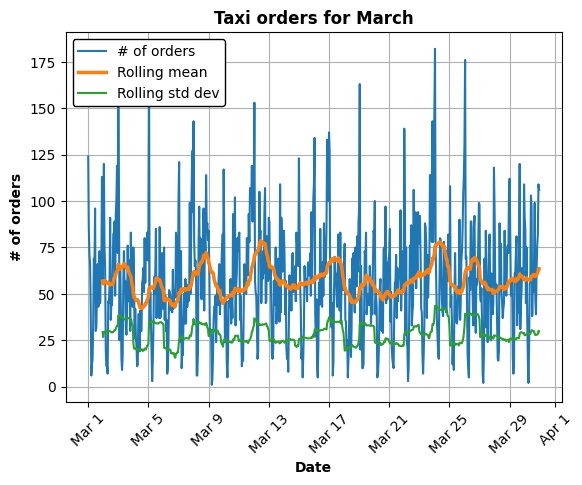

In [14]:
# Plot data for 1 month
labels = ['Mar 1', 'Mar 5', 'Mar 9', 'Mar 13', 'Mar 17', 'Mar 21', 'Mar 25', 'Mar 29', 'Apr 1']
fig, ax = plt.subplots()
plt.plot(data_analysis.iloc[:720].index, data_analysis['num_orders'].iloc[:720])
plt.plot(data_analysis.iloc[:720].index, data_analysis['rolling_mean_mon'].iloc[:720], linewidth=2.5)
plt.plot(data_analysis.iloc[:720].index, data_analysis['rolling_std_mon'].iloc[:720], linewidth=1.5)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')
plt.xticks(ticks=ax.get_xticks(), labels=labels, rotation=45)
plt.title('Taxi orders for March', fontweight='bold')
plt.legend(labels=['# of orders', 'Rolling mean', 'Rolling std dev'], loc='upper left', framealpha=1, edgecolor='black')
ax.grid('on')
plt.show()

<b>4 days</b>

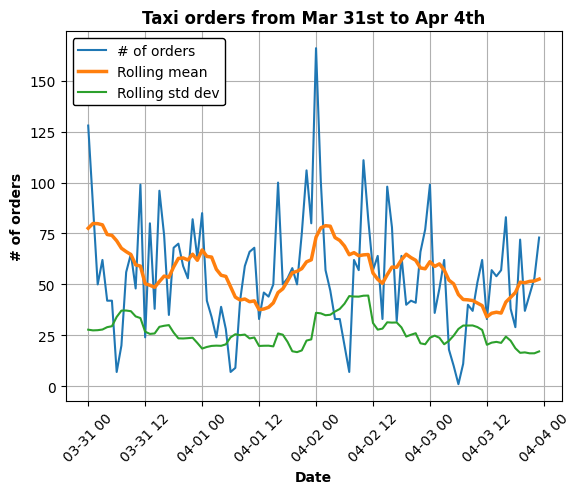

In [15]:
# Plot data for 4-day period (Mar 31st to Apr 4th)
fig, ax = plt.subplots()
plt.plot(data_analysis.iloc[720:816].index, data_analysis['num_orders'].iloc[720:816])
plt.plot(data_analysis.iloc[720:816].index, data_analysis['rolling_mean_day'].iloc[720:816], linewidth=2.5)
plt.plot(data_analysis.iloc[720:816].index, data_analysis['rolling_std_day'].iloc[720:816], linewidth=1.5)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')
plt.xticks(rotation=45)
plt.title('Taxi orders from Mar 31st to Apr 4th', fontweight='bold')
plt.legend(labels=['# of orders', 'Rolling mean', 'Rolling std dev'], loc='upper left', framealpha=1, edgecolor='black')
ax.grid('on')
plt.show()

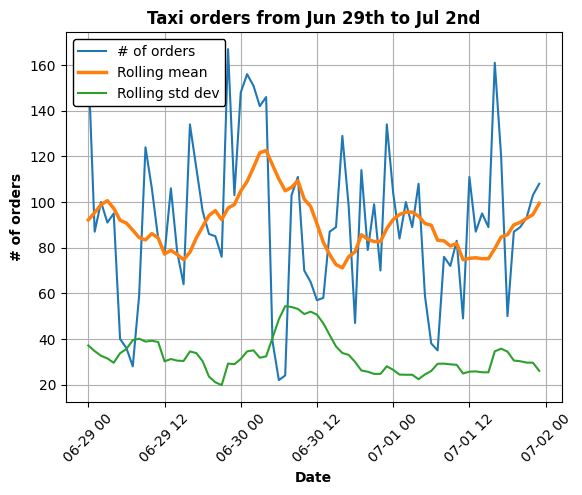

In [16]:
# Plot data for 4-day period (Jun 29th to Jul 2nd)
fig, ax = plt.subplots()
plt.plot(data_analysis.iloc[2880:2952].index, data_analysis['num_orders'].iloc[2880:2952])
plt.plot(data_analysis.iloc[2880:2952].index, data_analysis['rolling_mean_day'].iloc[2880:2952], linewidth=2.5)
plt.plot(data_analysis.iloc[2880:2952].index, data_analysis['rolling_std_day'].iloc[2880:2952], linewidth=1.5)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')
plt.xticks(rotation=45)
plt.title('Taxi orders from Jun 29th to Jul 2nd', fontweight='bold')
plt.legend(labels=['# of orders', 'Rolling mean', 'Rolling std dev'], loc='upper left', framealpha=1, edgecolor='black')
ax.grid('on')
plt.show()

### Trends and seasonality

Findings in trends, increases, and decreases in the previous analysis is also seen here in the <mark>Trend</mark> chart, but there is additional information provided around the <mark>Seasonality</mark> chart. For the 6 months, there is a precise pattern of identical ups and downs and the mean (orange line) is straight horizontal line. When you dive deeper into the <b>monthly</b> and <b>4 day</b> charts, exact patterns of increases and decreases for each day (for ex: Mar 1st vs Mar 2nd), and even at the same times from day to day (for ex: 1 PM on the Mar 1st vs 1 PM on the Mar 2nd), can be identified. This means that the number of orders from day to day, and even at the same times each day, are very similar to one another.

#### Seasonal-trend decomposition

<b>6 months</b>

In [17]:
# Break data into trend and seasonality components for all data
decompose = seasonal_decompose(data)
data_analysis = data_analysis.dropna()
decompose_rolling = seasonal_decompose(data_analysis['rolling_mean'])

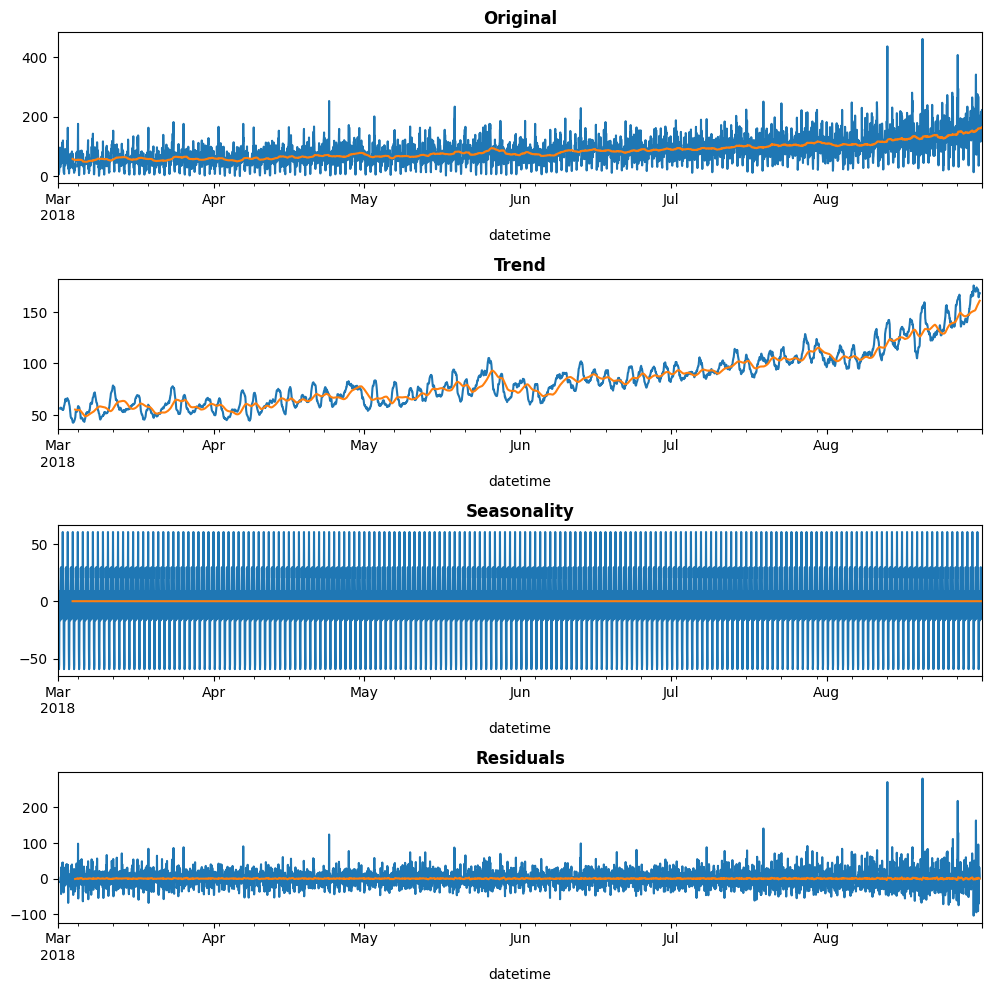

In [18]:
# Display plots
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 10))

plt.subplot(411)
decompose.observed.plot(ax=plt.gca())
decompose_rolling.observed.plot(ax=plt.gca())
plt.title('Original', fontweight='bold')
plt.subplot(412)
decompose.trend.plot(ax=plt.gca())
decompose_rolling.trend.plot(ax=plt.gca())
plt.title('Trend', fontweight='bold')
plt.subplot(413)
decompose.seasonal.plot(ax=plt.gca())
decompose_rolling.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', fontweight='bold')
plt.subplot(414)
decompose.resid.plot(ax=plt.gca())
decompose_rolling.resid.plot(ax=plt.gca())
plt.title('Residuals', fontweight='bold')

plt.tight_layout(1) 

<b>*1 month*</b>

In [19]:
# Break data into trend and seasonality components for 1 month
data_mon = data.iloc[720:1440]
data_analysis_mon = data_analysis.iloc[649:1368]
decompose_mon = seasonal_decompose(data_mon)
decompose_rolling_mon = seasonal_decompose(data_analysis_mon['rolling_mean_mon'])

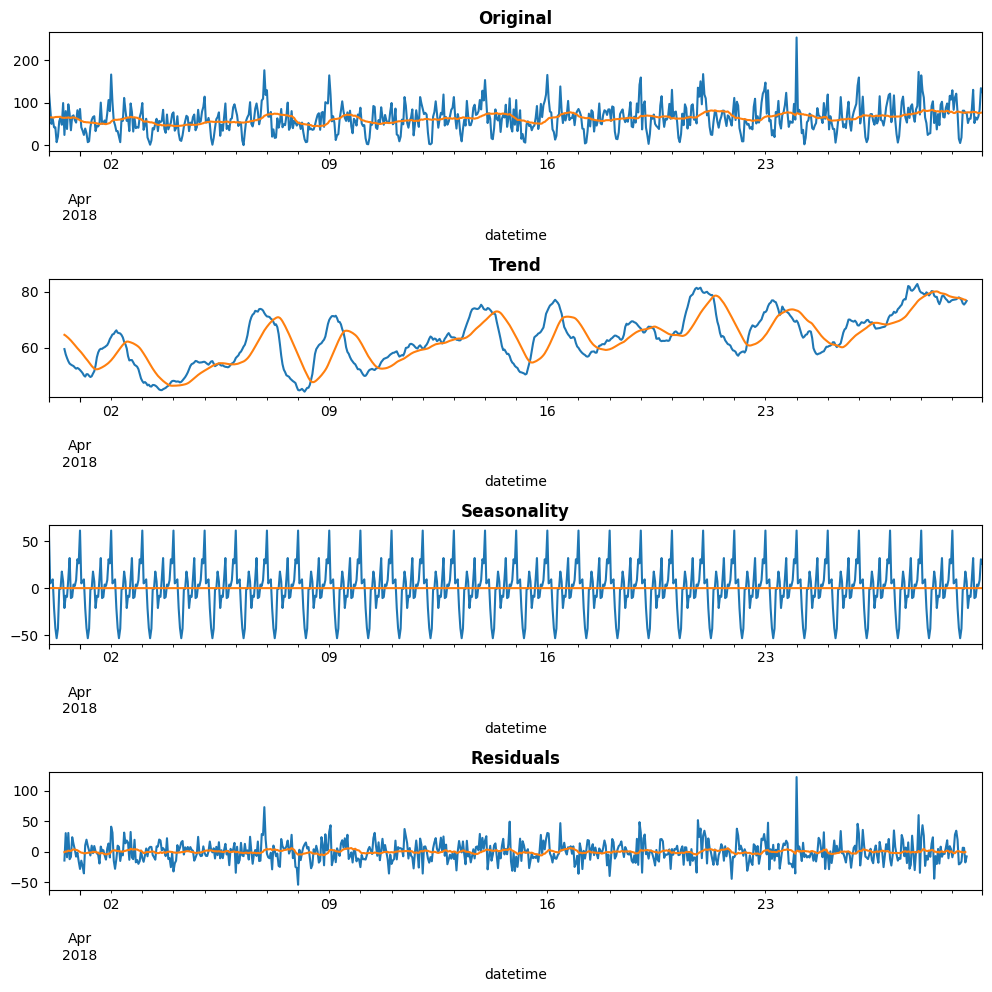

In [20]:
# Display plots
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 10))

plt.subplot(411)
decompose_mon.observed.plot(ax=plt.gca())
decompose_rolling_mon.observed.plot(ax=plt.gca())
plt.title('Original', fontweight='bold')
plt.subplot(412)
decompose_mon.trend.plot(ax=plt.gca())
decompose_rolling_mon.trend.plot(ax=plt.gca())
plt.title('Trend', fontweight='bold')
plt.subplot(413)
decompose_mon.seasonal.plot(ax=plt.gca())
decompose_rolling_mon.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', fontweight='bold')
plt.subplot(414)
decompose_mon.resid.plot(ax=plt.gca())
decompose_rolling_mon.resid.plot(ax=plt.gca())
plt.title('Residuals', fontweight='bold')

plt.tight_layout(1) 

<b>*4-day period*</b>

In [21]:
# Break data into trend and seasonality components for a 4-day period
data_day = data.iloc[720:816]
data_analysis_day = data_analysis.iloc[649:744]
decompose_day = seasonal_decompose(data_day)
decompose_rolling_day = seasonal_decompose(data_analysis_day['rolling_mean_day'])

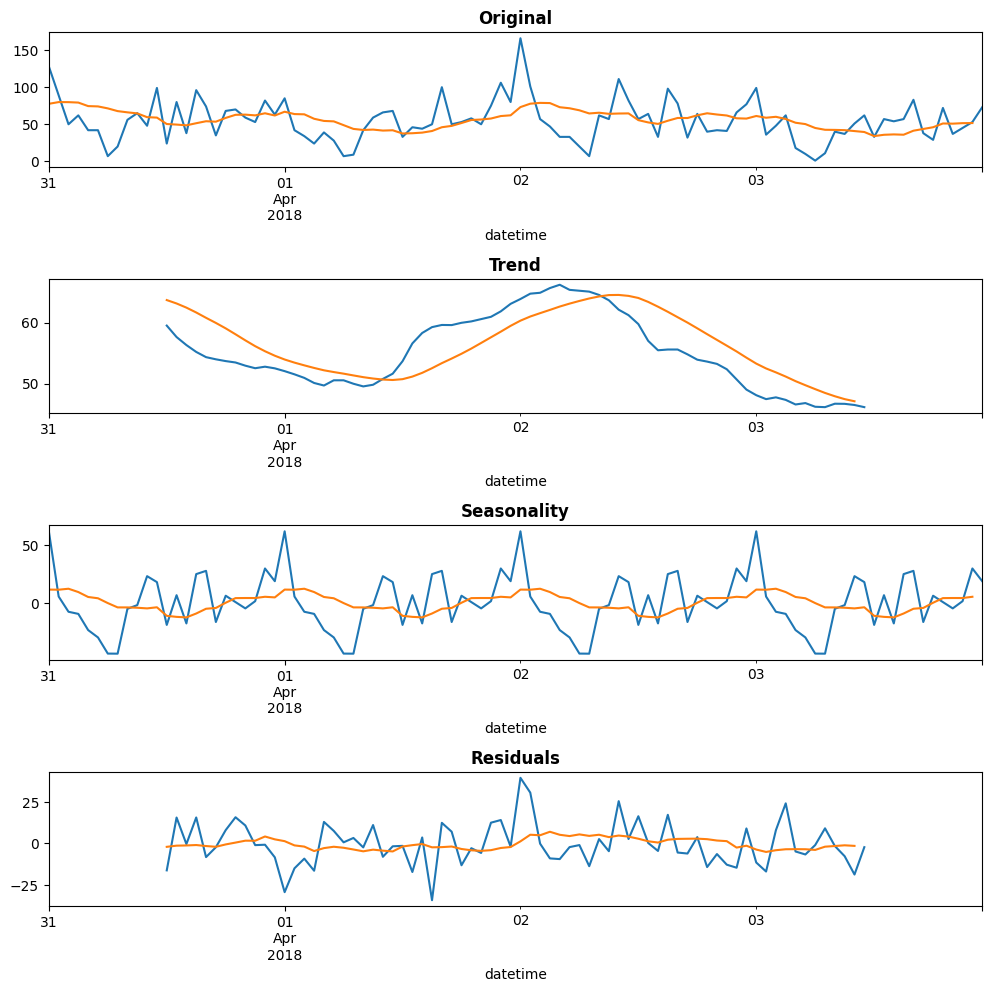

In [22]:
# Display plots
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 10))

plt.subplot(411)
decompose_day.observed.plot(ax=plt.gca())
decompose_rolling_day.observed.plot(ax=plt.gca())
plt.title('Original', fontweight='bold')
plt.subplot(412)
decompose_day.trend.plot(ax=plt.gca())
decompose_rolling_day.trend.plot(ax=plt.gca())
plt.title('Trend', fontweight='bold')
plt.subplot(413)
decompose_day.seasonal.plot(ax=plt.gca())
decompose_rolling_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', fontweight='bold')
plt.subplot(414)
decompose_day.resid.plot(ax=plt.gca())
decompose_rolling_day.resid.plot(ax=plt.gca())
plt.title('Residuals', fontweight='bold')

plt.tight_layout(1) 

#### Seasonal-trend decomposition using LOESS (STL)

STL is a method for decomposing time series data that uses the LOESS technique (locally estimated scatterplot smoothing) to estimate trend and seasonal components. This technique can adapt to complex, non-linear relationships and variations in the data, making it useful for handling outliers and complex seasonality. Moreover, this technique was used here to see if there were any differences in trends and seasonality that the technique above may have missed or overloooked.

The trends and seasonality resulting from the LOESS technique provide similar insights and patterns in the data as above. However, the data is more smoothed, and there are variations in the seasonality at the <b>monthly</b> and <b>4 day</b> levels (whereas in the analysis above the patterns were exact from day to day), but there are no major differences between the two techniques and analyses.

<b>6 months</b>

In [23]:
# Break data into trend and seasonality components using STL
stl = STL(data)
result_stl = stl.fit()

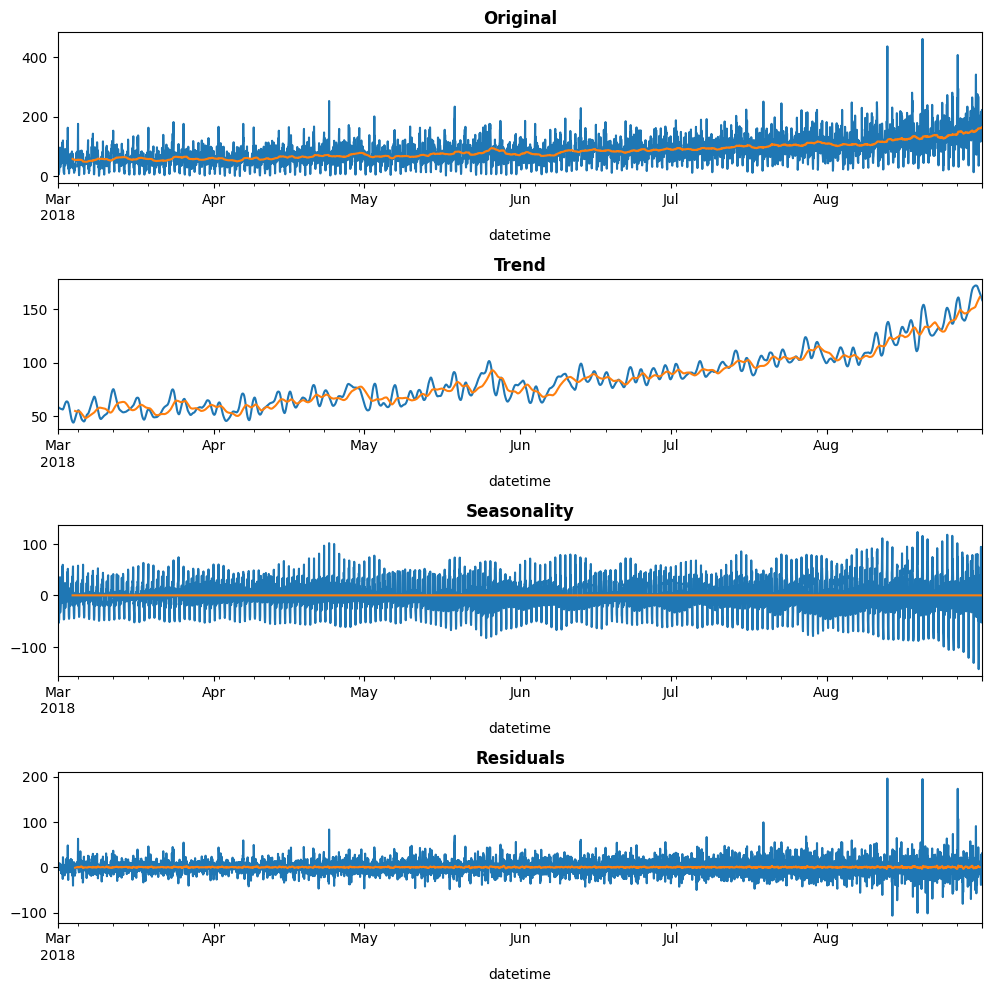

In [24]:
# Display plots
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 10))

plt.subplot(411)
result_stl.observed.plot(ax=plt.gca())
decompose_rolling.observed.plot(ax=plt.gca())
plt.title('Original', fontweight='bold')
plt.legend().remove()
plt.subplot(412)
result_stl.trend.plot(ax=plt.gca())
decompose_rolling.trend.plot(ax=plt.gca())
plt.title('Trend', fontweight='bold')
plt.subplot(413)
result_stl.seasonal.plot(ax=plt.gca())
decompose_rolling.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', fontweight='bold')
plt.subplot(414)
result_stl.resid.plot(ax=plt.gca())
decompose_rolling.resid.plot(ax=plt.gca())
plt.title('Residuals', fontweight='bold')

plt.tight_layout(1) 

<b>1 month</b>

In [25]:
# Break data into trend and seasonality components for 1 month
mon = data.iloc[720:1440]
stl = STL(mon)
result_stl = stl.fit()

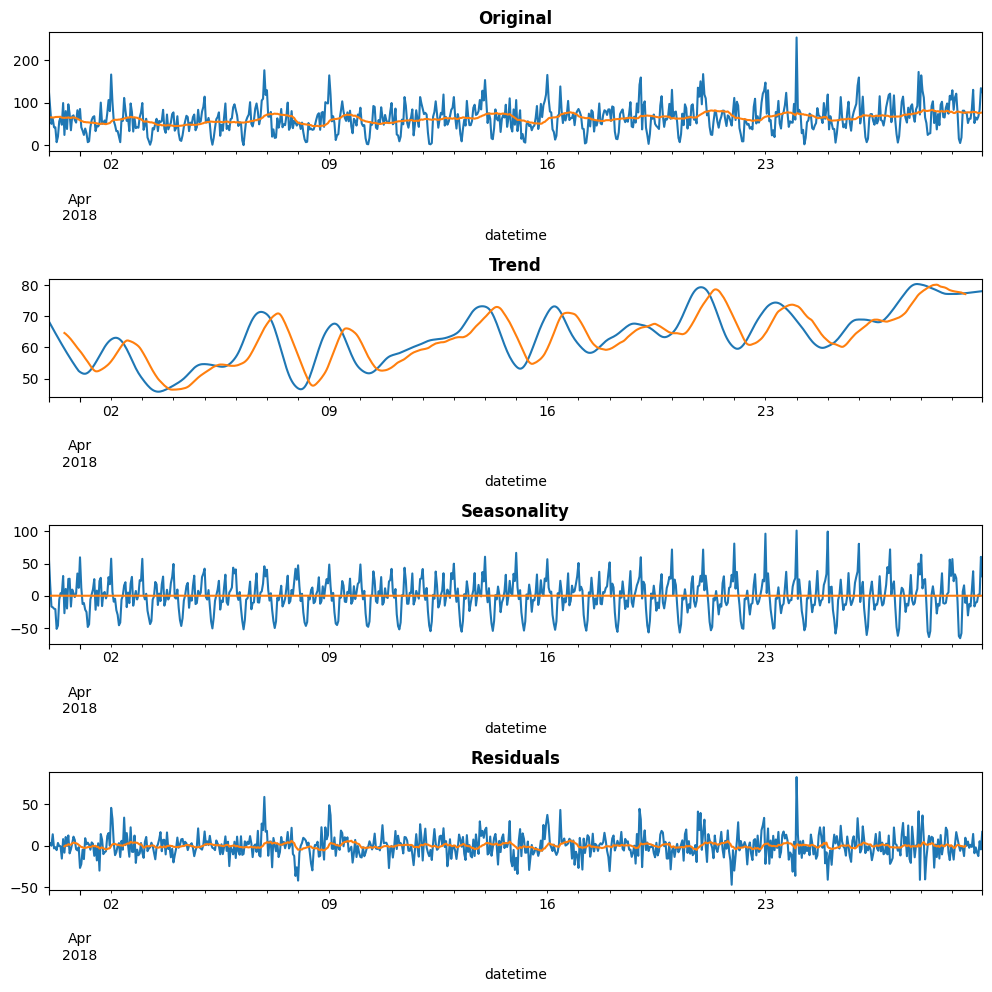

In [26]:
# Display plots
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 10))

plt.subplot(411)
result_stl.observed.plot(ax=plt.gca())
decompose_rolling_mon.observed.plot(ax=plt.gca())
plt.title('Original', fontweight='bold')
plt.legend().remove()
plt.subplot(412)
result_stl.trend.plot(ax=plt.gca())
decompose_rolling_mon.trend.plot(ax=plt.gca())
plt.title('Trend', fontweight='bold')
plt.subplot(413)
result_stl.seasonal.plot(ax=plt.gca())
decompose_rolling_mon.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', fontweight='bold')
plt.subplot(414)
result_stl.resid.plot(ax=plt.gca())
decompose_rolling_mon.resid.plot(ax=plt.gca())
plt.title('Residuals', fontweight='bold')

plt.tight_layout(1) 

<b>4 day</b>

In [27]:
# Break data into trend and seasonality components for a 4-day period
day = data.iloc[720:816]
stl = STL(day)
result_stl = stl.fit()

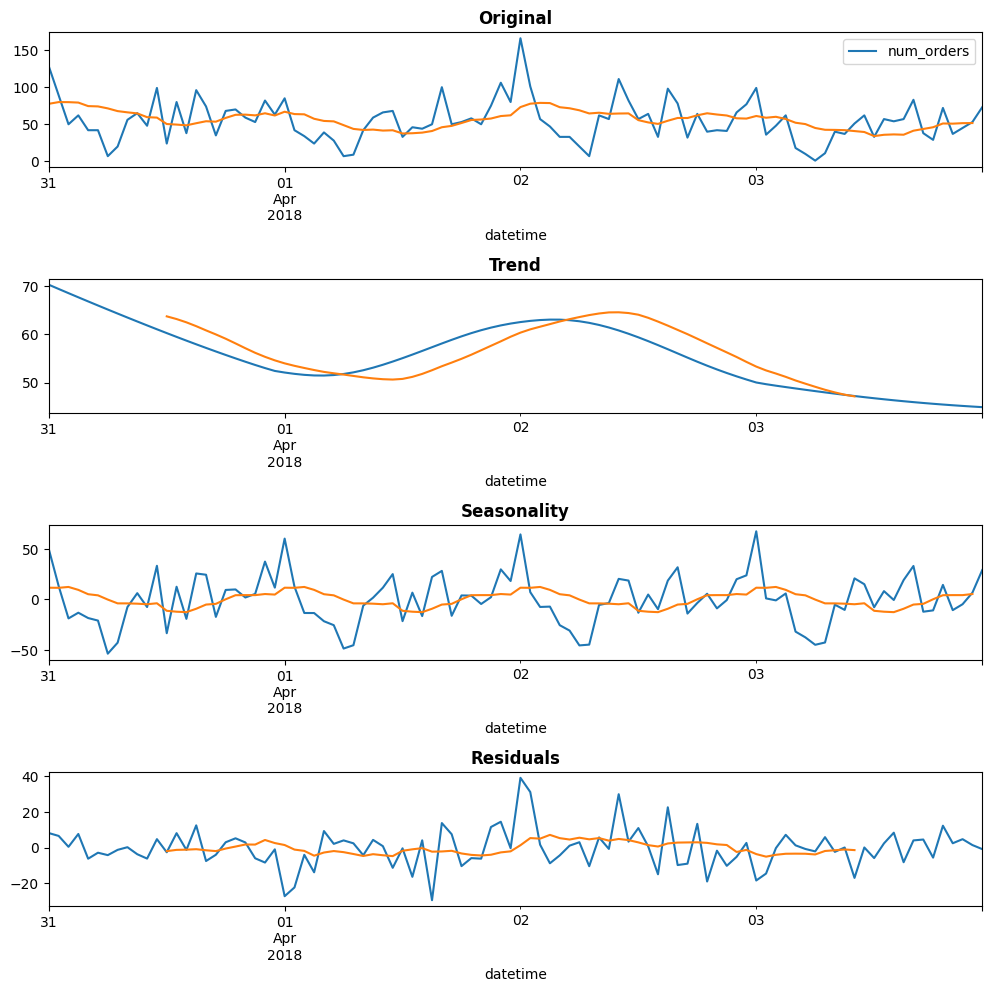

In [28]:
# Display plots
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 10))

plt.subplot(411)
result_stl.observed.plot(ax=plt.gca())
decompose_rolling_day.observed.plot(ax=plt.gca())
plt.title('Original', fontweight='bold')
plt.subplot(412)
result_stl.trend.plot(ax=plt.gca())
decompose_rolling_day.trend.plot(ax=plt.gca())
plt.title('Trend', fontweight='bold')
plt.subplot(413)
result_stl.seasonal.plot(ax=plt.gca())
decompose_rolling_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', fontweight='bold')
plt.subplot(414)
result_stl.resid.plot(ax=plt.gca())
decompose_rolling_day.resid.plot(ax=plt.gca())
plt.title('Residuals', fontweight='bold')

plt.tight_layout(1) 

## Training

### Model preparation

1. <b>Features and target</b>

    - The following features were added as features for model building and training. The target is <b><mark>num_orders</mark></b>.</br></br>
    
        - <b><mark>hour</mark></b>
        - <b><mark>day</mark></b>
        - <b><mark>dayofweek</mark></b>
        - <b><mark>month</mark></b>
        - <b><mark>lag_1</mark></b> to <b><mark>lag_48</mark></b>
        - <b><mark>rolling_mean</mark></b> (size of 72)
</br>
</br>
2. <b>Time series stationarity</b>:

    - The data was tested to see if it was stationary or non-stationary using a Dickey-Fuller test. The resulting p-value was <b>0.0289</b>, which is less than the <b>0.05</b> statistical significance. This concludes that the data is stationary, so no clean-up here was needed.
</br>
</br>
1. <b>Training, validation, and test datasets</b>:

    - The data was split into training, validation, and test datasets with a <b>76.5</b> / <b>13.5</b> / <b>10</b> split. This ensures that there is ample data to accurately train the model, but there are still sets to validate and test the evaluation of the model.

#### Features and target

In [29]:
# Create features function
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [30]:
# Create features
make_features(data, 48, 72)
display(data.head())

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Drop NaN values
data = data.dropna()

# Define features and target
features = data.drop('num_orders', axis=1)
target = data['num_orders']

#### Time series stationarity

In [32]:
# Apply Dickey-Fuller test to 'num_orders'
data_stationarityTest = adfuller(target, autolag='AIC')
print('P-value: ', data_stationarityTest[1])
print()
conf_int = 0.05
if data_stationarityTest[1] < conf_int:
    print('Data is stationary!')
else:
    print('Data is not stationary!')

P-value:  0.029298774797137467

Data is stationary!


#### Training, validation, and test datasets

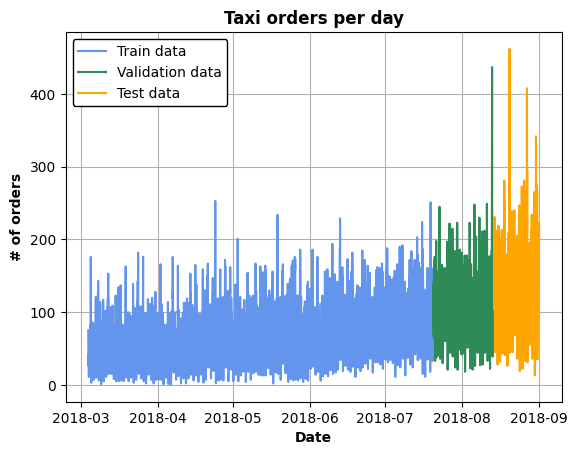

In [33]:
# Split data into training, validation, and test datasets
train_features, test_features, train_target, test_target = train_test_split(features, target, shuffle=False, test_size=0.1)
train_features, validation_features, train_target, validation_target = train_test_split(train_features, train_target, shuffle=False, test_size=0.15)

# Display plot
fig, ax = plt.subplots()
plt.plot(train_features.index, train_target, color='cornflowerblue', label='Train data')
plt.plot(validation_features.index, validation_target, color='seagreen', label='Validation data')
plt.plot(test_features.index, test_target, color='orange', label='Test data')
plt.legend(loc='upper left', framealpha=1, edgecolor='black')
plt.title('Taxi orders per day', fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('# of orders', fontweight='bold')
ax.grid('on')
plt.show()

### Model training and tuning

#### Autoregression

An autoregressive model was the first model built and fine-tuned. The following steps were performed to tune the model. 

1. Find the optimal number of lags
2. Test the seasonal parameter (True vs False)

After the optimal number of lags was determined, this was used for the next two model tests. The best model had an order of <b><font color='red'>72</font></b> with the seasonal parameter set to <b><font color='red'>True</font></b>. Below were the RMSE metrics, and both beat the threshold of <b>48</b>.

- Lag of [1:72], seasonal = False --- <b><font color='red'>39.69</font></b>
- Lag of [1:72], seasonal = True --- <b><font color='red'>36.82</font></b>

In [34]:
# Find optimal # of lags
find_ar_lags = ar_select_order(endog=train_target, maxlag=100)
opt_ar_lags = find_ar_lags.ar_lags
print('Lags that define the AR model order:', opt_ar_lags)

Lags that define the AR model order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]


const             3.625360
num_orders.L1     0.163507
num_orders.L2     0.117478
num_orders.L3     0.041974
num_orders.L4     0.054110
                    ...   
num_orders.L68   -0.029104
num_orders.L69    0.001841
num_orders.L70   -0.056081
num_orders.L71    0.031963
num_orders.L72    0.220868
Length: 73, dtype: float64

RMSE:  39.69


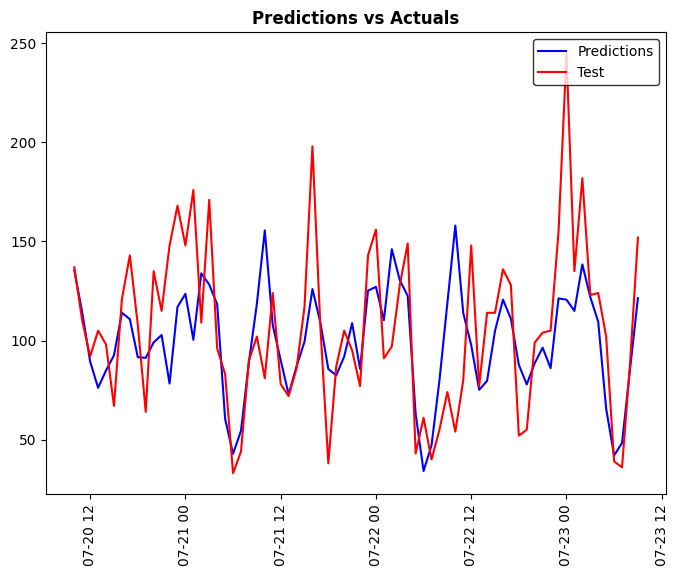

In [35]:
# Train model where seasonal = False
model_ar = AutoReg(train_target, lags=opt_ar_lags, seasonal=False)
model_ar = model_ar.fit()
print(model_ar.params)
print()

# Gather predictions
start_value = len(train_features)
end_value = len(train_features) + len(validation_features) - 1
preds = model_ar.predict(start=start_value, end=end_value, dynamic=False)

# Evaluate model
mse = mean_squared_error(validation_target, preds)
rmse = mse ** 0.5
print('RMSE: ', rmse.round(2))

# Display evaluation plot
plt.figure(figsize=(8, 6))
plt.plot(preds[:72], color='blue', label='Predictions')
plt.plot(validation_target[:72], color='red', label='Test')
plt.legend(loc='upper right', edgecolor='black')
plt.title('Predictions vs Actuals', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

const             33.377064
s(2,24)          -30.411268
s(3,24)          -27.053255
s(4,24)          -32.383379
s(5,24)          -40.428169
                    ...    
num_orders.L68    -0.023365
num_orders.L69     0.008812
num_orders.L70    -0.060672
num_orders.L71     0.012420
num_orders.L72     0.139874
Length: 96, dtype: float64

RMSE:  36.82


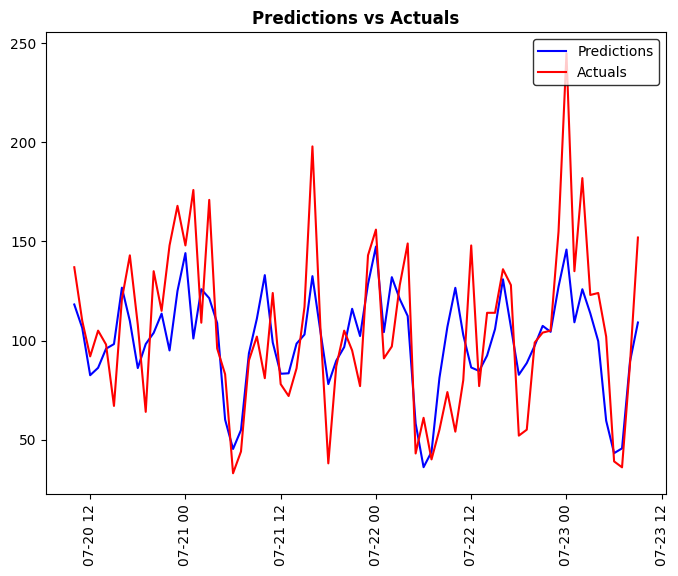

In [36]:
# Train model where seasonal = True
model_ar = AutoReg(train_target, lags=opt_ar_lags, seasonal=True)
model_ar = model_ar.fit()
print(model_ar.params)
print()

# Gather predictions
start_value = len(train_features)
end_value = len(train_features) + len(validation_features) - 1
preds = model_ar.predict(start=start_value, end=end_value, dynamic=False)

# Evaluate model
mse = mean_squared_error(validation_target, preds)
rmse = mse ** 0.5
print('RMSE: ', rmse.round(2))

# Display evaluation plot
plt.figure(figsize=(8, 6))
plt.plot(preds[:72], color='blue', label='Predictions')
plt.plot(validation_target[:72], color='red', label='Actuals')
plt.legend(loc='upper right', edgecolor='black')
plt.title('Predictions vs Actuals', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

#### Moving average

The second model was a moving average model. First, the optimal maximum order for the model was determined, which was <b><font color='red'>8</font></b>. This was thenused as a parameter for training the model. After gathering predictions, the model yielded a RMSE of <b><font color='red'>56.52</font></b>, worse than the autogression model. Also, in looking at the graph below that displays the differences between the predictions and actuals, the predictions were eventually just 0. Moreover, the RMSE does not beat the threshold of <b>48</b>, the model is really not making any impactful predictions.

In [37]:
# Find optimal order
warnings.filterwarnings('ignore')
find_ma_order = arma_order_select_ic(y=train_target, max_ar=0, max_ma=10)
opt_ma_order = find_ma_order.bic_min_order[1]
print('Best order for MA model:', opt_ma_order)

Best order for MA model: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                 3322
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -15923.038
Date:                Wed, 16 Apr 2025   AIC                          31866.076
Time:                        17:15:00   BIC                          31927.159
Sample:                    03-04-2018   HQIC                         31887.934
                         - 07-20-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.3634      1.282     57.237      0.000      70.851      75.876
ma.L1          0.4766      0.016     30.012      0.000       0.445       0.508
ma.L2          0.3755      0.018     20.843      0.000       0.340       0.411
ma.L3          0.2008      0.019     10.772      0.000       0.164       0.237
ma.L4          0.0747      0.020      3.779      0.000       0.036       0.113
ma.L5          0.0223      0.020      1.092      0.275      -0.018       0.062
ma.L6         -0.0406      0.021     -1.949      0.051      -0.081       0.000
ma.L7          0.0647      0.019      3.337      0.001       0.027       0.103
ma.L8          0.1481      0.018      8.223      0.000       0.113       0.183
sigma2       852.6420     18.228     46.777      0.000     816.916     888.368
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               260.11
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE:  56.524383140140415


(array([17733., 17737., 17741., 17744., 17748., 17752., 17756.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

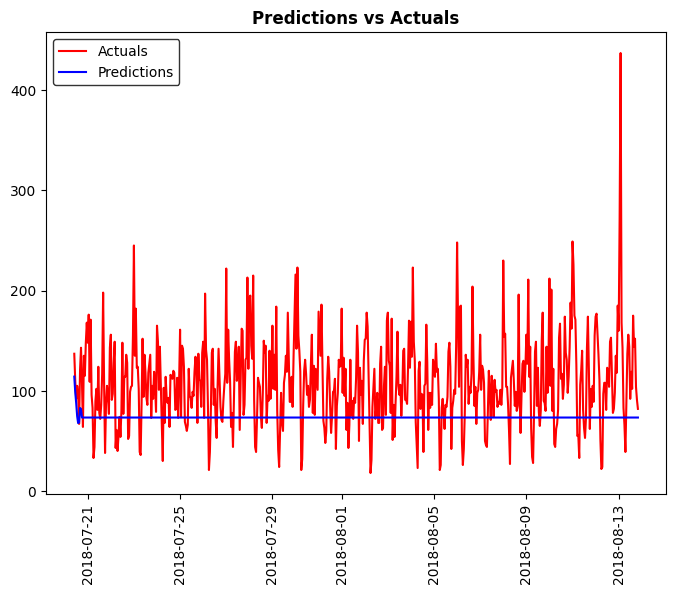

In [38]:
# Train model
model_ma = ARIMA(train_target, order=(0, 0, opt_ma_order))
model_ma = model_ma.fit()
display(model_ma.summary())

# Gather predictions
start_value = len(train_features)
end_value = len(train_features) + len(validation_features) - 1
warnings.filterwarnings('ignore')
preds = model_ma.predict(start=start_value, end=end_value, dynamic=False)

# Evaluate model
mse = mean_squared_error(validation_target, preds)
rmse = mse ** 0.5
print('RMSE: ', rmse)

# Display evaluation plot
plt.figure(figsize=(8, 6))
plt.plot(validation_target, color='red', label='Actuals')
plt.plot(preds, color='blue', label='Predictions')
plt.legend(loc='upper left', edgecolor='black')
plt.title('Predictions vs Actuals', fontweight='bold')
plt.xticks(rotation=90)

#### ARIMA

The third model that was created and fine-tuned was an ARIMA model. Many different order combinations were used through a for loop to find the best performing model. The best model had an order combination of <b><font color='red'>(70, 1, 8)</font></b> with an RMSE of <b><font color='red'>36.88</font></b>. Also, in looking at the graph, the predicitons are not a straight horizontal line as the moving average model resulted in, but as time gets farther in the future, the predictions do start to flatten out and the predictions become "farther apart" from the actual results. It seems that the moving average technique does not perform well with this dataset.

<b>NOTE</b>: Due to the time it took to run the <b>for loop</b> of different parameter (p, d, q) combinations, this code cell is commented out to prevent the extremely long run times. In addition, the different orders (p, d, q) currently in the code cell were just some combinations that were used in the for loop. Many more combinations were experimented. The code cell below has the order combination that performed the best. Lastly, the results of the for loop are in a markdown cell below as well.

RMSE:  36.88


(array([17733., 17737., 17741., 17744., 17748., 17752., 17756.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

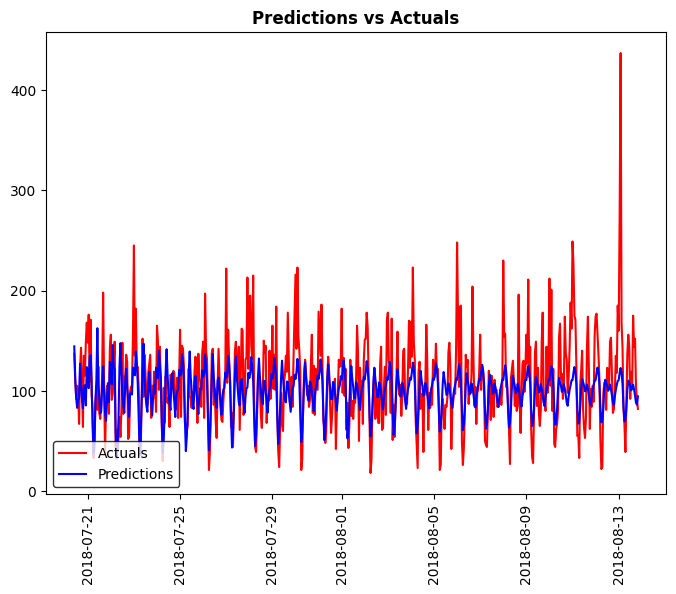

In [39]:
# Set parameter values
ar_order = 70
d_order = 1
ma_order = 8
order = (ar_order, d_order, ma_order)

# Train model
model_arima = ARIMA(train_target, order=order)
model_arima = model_arima.fit()

# Gather predictions
start_value = len(train_features)
end_value = len(train_features) + len(validation_features) - 1
warnings.filterwarnings('ignore')
preds = model_arima.predict(start=start_value, end=end_value)

# Evaluate model
mse = mean_squared_error(validation_target, preds)
rmse = mse ** 0.5
print('RMSE: ', rmse.round(2))

# Display evaluation plot
plt.figure(figsize=(8, 6))
plt.plot(validation_target, color='red', label='Actuals')
plt.plot(preds, color='blue', label='Predictions')
plt.legend(loc='lower left', edgecolor='black')
plt.title('Predictions vs Actuals', fontweight='bold')
plt.xticks(rotation=90)

In [40]:
'''
# Set parameter values
p_values = [10, 20, 30]
d_values = [1, 2, 3]
q_values = [4, 6, 8]

# Define start and end values
start_value = len(train_features)
end_value = len(train_features) + len(validation_features) - 1

# Create for loop to iterate through hyperparamter values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            warnings.filterwarnings('ignore')
            model_arima = ARIMA(train_target, order=order).fit()
            preds = model_arima.predict(start=start_value, end=end_value)
            mse = mean_squared_error(validation_target, preds)
            rmse = mse ** 0.5
            print('Order:', order, ' --- ', 'RMSE:', rmse)
'''

"\n# Set parameter values\np_values = [10, 20, 30]\nd_values = [1, 2, 3]\nq_values = [4, 6, 8]\n\n# Define start and end values\nstart_value = len(train_features)\nend_value = len(train_features) + len(validation_features) - 1\n\n# Create for loop to iterate through hyperparamter values\nfor p in p_values:\n    for d in d_values:\n        for q in q_values:\n            order = (p, d, q)\n            warnings.filterwarnings('ignore')\n            model_arima = ARIMA(train_target, order=order).fit()\n            preds = model_arima.predict(start=start_value, end=end_value)\n            mse = mean_squared_error(validation_target, preds)\n            rmse = mse ** 0.5\n            print('Order:', order, ' --- ', 'RMSE:', rmse)\n"

<b>Results from the above for loop that tests p, d, q parameters</b>

Order: (10, 1, 4)  ---  RMSE: 45.41997576320285</br>
Order: (10, 1, 6)  ---  RMSE: 44.951315527840684</br>
Order: (10, 1, 8)  ---  RMSE: 43.59417803221861</br>
Order: (10, 2, 4)  ---  RMSE: 44.06563638179433</br>
Order: (10, 2, 6)  ---  RMSE: 101.31813614400507</br>
Order: (10, 2, 8)  ---  RMSE: 45.9189533996197</br>
Order: (10, 3, 4)  ---  RMSE: 797.7909802916056</br>
Order: (10, 3, 6)  ---  RMSE: 2575.100160705552</br>
Order: (10, 3, 8)  ---  RMSE: 858.4813284319184</br>
Order: (20, 1, 4)  ---  RMSE: 42.484825474881674</br>
Order: (20, 1, 6)  ---  RMSE: 42.111196880276125</br>
Order: (20, 1, 8)  ---  RMSE: 41.101737008143935</br>
Order: (20, 2, 4)  ---  RMSE: 43.383643134127844</br>
Order: (20, 2, 6)  ---  RMSE: 43.5505759319675</br>
Order: (20, 2, 8)  ---  RMSE: 42.33781046138009</br>
Order: (20, 3, 4)  ---  RMSE: 653.1307867270731</br>
Order: (20, 3, 6)  ---  RMSE: 471.1844081452624</br>
Order: (20, 3, 8)  ---  RMSE: 270.07584206459364</br>
Order: (30, 1, 4)  ---  RMSE: 44.46376326698664</br>
Order: (30, 1, 6)  ---  RMSE: 41.61695653397519</br>
Order: (30, 1, 8)  ---  RMSE: 41.74941054669394</br>
Order: (30, 2, 4)  ---  RMSE: 43.00498587252028</br>
Order: (30, 2, 6)  ---  RMSE: 43.12753583876097</br>
Order: (30, 2, 8)  ---  RMSE: 44.0967447437996</br>
Order: (30, 3, 4)  ---  RMSE: 51.42990833216524</br>
Order: (30, 3, 6)  ---  RMSE: 571.5850651369328</br>
Order: (30, 3, 8)  ---  RMSE: 147.20384729835973

#### Linear regression

The last model was a linear regression. Features were originally created that were used here to help train and fit the model. Fine-tuning of these features, specifically <b><mark>max_lag</mark></b> and <b><mark>rolling_mean_size</mark></b>, was done to maximize model accuracy. A <b><mark>max_lag</mark></b> of <b><font color='red'>48</font></b> and <b><mark>rolling_mean_size</mark></b> of <b><font color='red'>72</font></b> yielded the best RMSE, which was <b><font color='red'>31.02</font></b>.

RMSE:  31.02


(array([17733., 17737., 17741., 17744., 17748., 17752., 17756.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

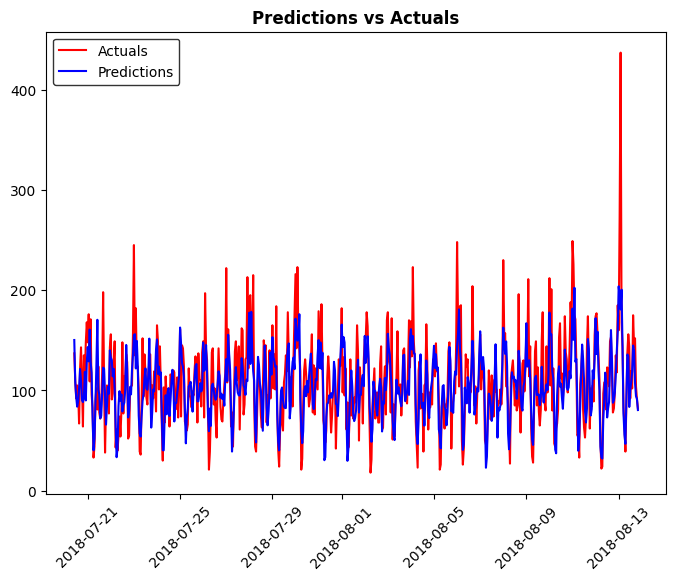

In [41]:
# Train model
model_lr = LinearRegression()
model_lr.fit(train_features, train_target)

# Gather predictions
preds = model_lr.predict(validation_features)

# Evaluate model
mse = mean_squared_error(validation_target, preds)
rmse = mse ** 0.5
print('RMSE: ', rmse.round(2))

# Display evaluation plot
plt.figure(figsize=(8, 6))
plt.plot(validation_target.index, validation_target, color='red', label='Actuals')
plt.plot(validation_target.index, preds, color='blue', label='Predictions')
plt.legend(loc='upper left', edgecolor='black')
plt.title('Predictions vs Actuals', fontweight='bold')
plt.xticks(rotation=45)

#### Conclusion

The below table provides an evaluation summary of the different models after parameter fine-tuning. The best performing model is the autoregression model. This model will be used for final model testing.

In [48]:
# Compare all models
RMSE_dict = {'RMSE': [36.82, 56.52, 36.88, 31.02]}
model_table = pd.DataFrame(RMSE_dict, index=['Autogression', 'Moving average', 'ARIMA', 'Linear regression'])
display(model_table)

,RMSE
Autogression,36.82
Moving average,56.52
ARIMA,36.88
Linear regression,31.02


## Testing

### Linear regression

In [45]:
# Concatentate train and validation datasets
train_features_combine = pd.concat([train_features, validation_features])
train_target_combine = pd.concat([train_target, validation_target])

RMSE:  43.58


(array([17756., 17758., 17760., 17762., 17764., 17766., 17768., 17770.,
        17772., 17774., 17775.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

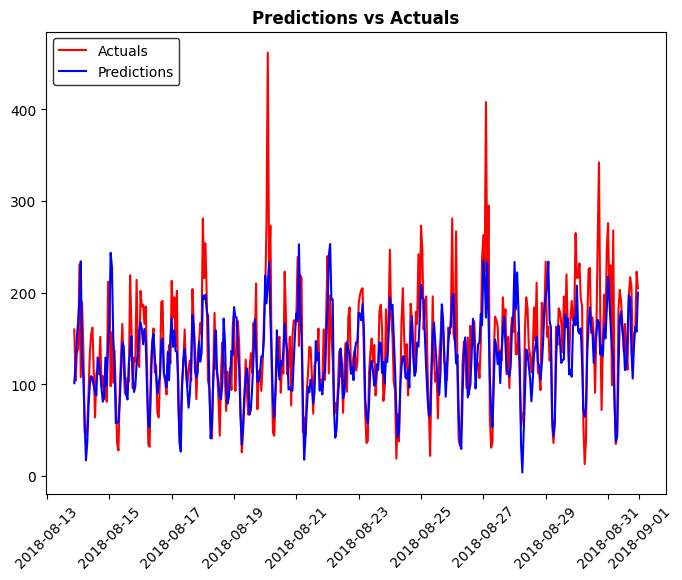

In [46]:
# Train model
model_lr = LinearRegression()
model_lr.fit(train_features_combine, train_target_combine)

# Gather predictions
preds = model_lr.predict(test_features)

# Evaluate model
mse = mean_squared_error(test_target, preds)
rmse = mse ** 0.5
print('RMSE: ', rmse.round(2))

# Display evaluation plot
plt.figure(figsize=(8, 6))
plt.plot(test_target.index, test_target, color='red', label='Actuals')
plt.plot(test_target.index, preds, color='blue', label='Predictions')
plt.legend(loc='upper left', edgecolor='black')
plt.title('Predictions vs Actuals', fontweight='bold')
plt.xticks(rotation=45)

# Conclusion

4 models different models were built and experimented with the goal to predict future taxi orders: autoregression, moving average, ARIMA, and linear regression. After model training and paramter tuning, the linear regression model performed the best and was used for final model evaluation. After testing and evaluating the model, the model yielded a RMSE of <b><font color='red'>43.58</font></b>, which does not beat the threshold of <b>48</b>.